In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

In [2]:
df_shoes = pd.read_csv('post_analysis_shoes.csv')
df_shoes.shape

(8064, 18)

In [3]:
def plot_value_counts(df,column,kind,rotation=None):
    if(kind == 'barh'):
        plt.figure(figsize=(10,25))
    else:
        plt.figure(figsize=(16,5))
    (df[column].value_counts()/len(df)).plot(kind=kind,title=f"{column}")
    if(rotation):
        plt.xticks(rotation=rotation)
    plt.show()

In [4]:
known_brands = ['olympikus', 'under_armour', 'nike', 'adidas', 'mizuno','asics','mormaii','puma',
        'oakley','fila','kappa', 'all star','gonew','new balance']

df_shoes = df_shoes[df_shoes['brand'].isin(known_brands)]

In [5]:
df_shoes.shape

(4462, 18)


brand:
['olympikus', 'nike', 'adidas', 'gonew', 'asics', 'kappa', 'puma', 'mizuno', 'fila', 'new balance', 'mormaii', 'oakley', 'all star']


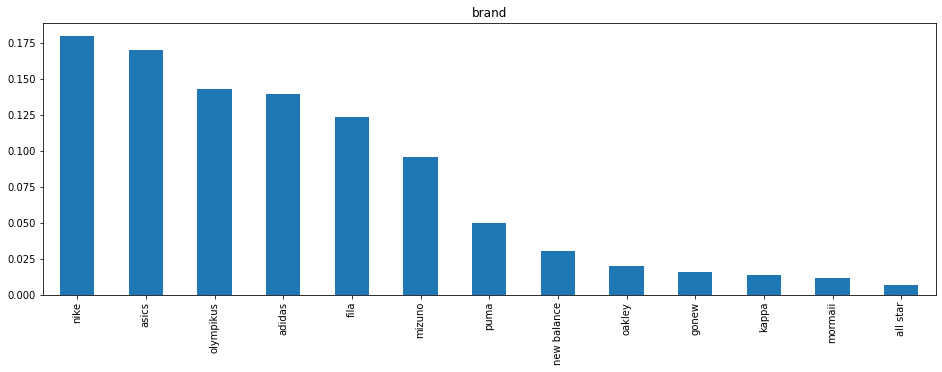


gender:
['feminino', 'masculino', 'unissex']


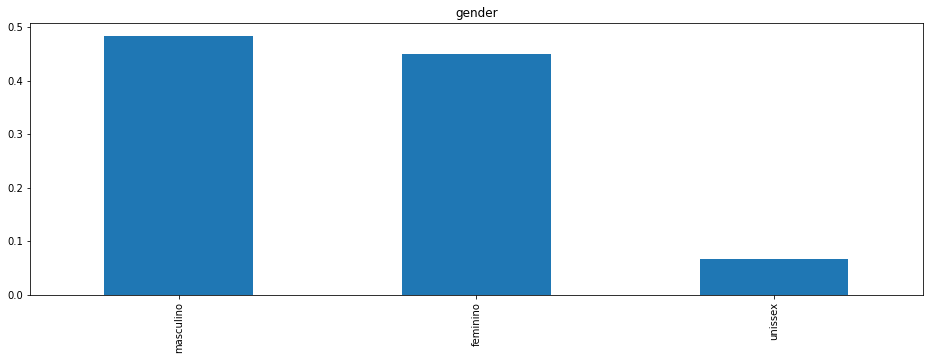

In [6]:
tag_columns = ['brand', 'gender']

for col in tag_columns:
    print(f'\n{col}:')
    print(list(df_shoes[col].unique()))
    
    plot_value_counts(df_shoes,col,'bar')

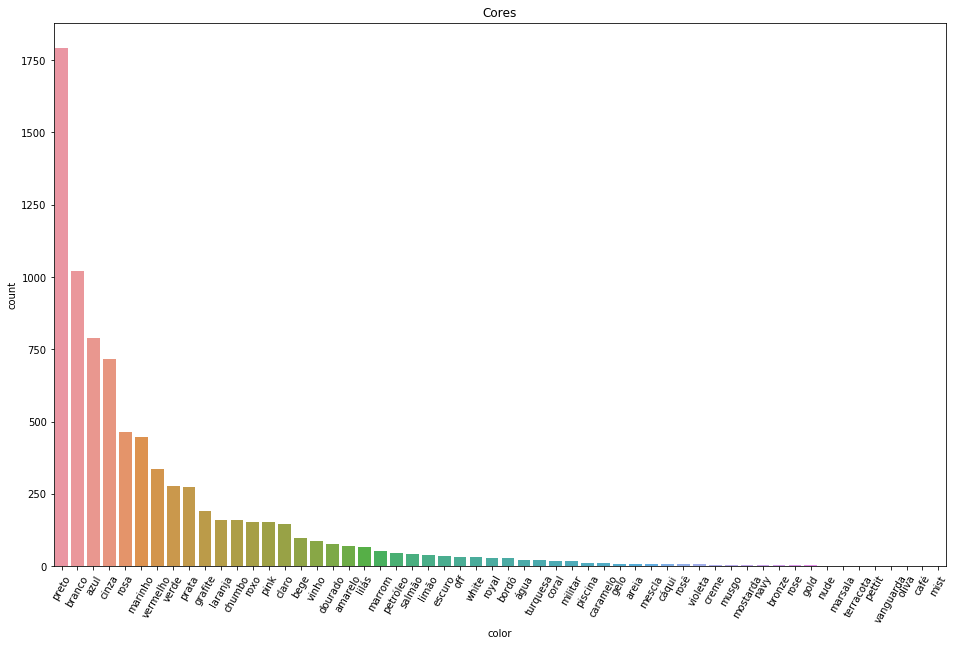

In [7]:
colors = []
[[colors.append(color) for color in row.split(',')] for row in df_shoes['colors'].values]
counts = np.asarray(np.unique(colors,return_counts=True)).T
counts = pd.DataFrame(counts,columns=['color','count'])
counts['count'] = counts['count'].astype(float)
counts = counts.sort_values('count',ascending=False)

plt.figure(figsize=(16,10))
sns.barplot(x='color',y='count',data=counts)
plt.title("Cores")
plt.xticks(rotation=60)
plt.show()

# Preprocessing Functions

In [8]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
def get_image_labels(df,label_col,image_col,base_path):
    new_df = pd.concat([pd.Series(row[label_col], row[image_col].split(','))              
                    for _, row in df.iterrows()]).reset_index()
    
    new_df.columns = [image_col,label_col]
    new_df[image_col] = new_df[image_col].apply(lambda row: os.path.join(base_path,row))
    
    return new_df

In [10]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [11]:
base_path = '/home/raphael/Documents/Projects/netshoes_ml_project/netshoes/images/'
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            rotation_range=45,
                                            width_shift_range=.15,
                                            height_shift_range=.15,
                                            horizontal_flip=True,
                                            zoom_range=0.5)

validation_image_generator = ImageDataGenerator(rescale=1./255)

# Marca

In [12]:
df_data = get_image_labels(df_shoes,'brand','images',base_path)
df_data.shape

(19290, 2)

In [13]:
IMG_SHAPE = (600,600)

efficient_net_url = "https://tfhub.dev/google/efficientnet/b7/feature-vector/1"

feature_extractor_layer = hub.KerasLayer(efficient_net_url,
                                         input_shape=IMG_SHAPE+(3,))
feature_extractor_layer.trainable = False

model = Sequential([
    feature_extractor_layer,
    Dense(32),
    Dense(df_data['brand'].nunique())
])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2560)              64097680  
_________________________________________________________________
dense (Dense)                (None, 32)                81952     
_________________________________________________________________
dense_1 (Dense)              (None, 13)                429       
Total params: 64,180,061
Trainable params: 82,381
Non-trainable params: 64,097,680
_________________________________________________________________


In [14]:
train, valid = train_test_split(df_data,
                                test_size=0.15,
                                stratify=df_data['brand'].values,
                                random_state=42)

train_data_gen = train_image_generator.flow_from_dataframe(train,
                                          x_col='images',
                                          y_col='brand',
                                          shuffle=True,
                                          batch_size=256,
                                          target_size=IMG_SHAPE)

val_data_gen = validation_image_generator.flow_from_dataframe(valid,
                                              x_col='images',
                                              y_col='brand',
                                              shuffle=True,
                                              batch_size=256,
                                              target_size=IMG_SHAPE)

Found 16396 validated image filenames belonging to 13 classes.
Found 2894 validated image filenames belonging to 13 classes.


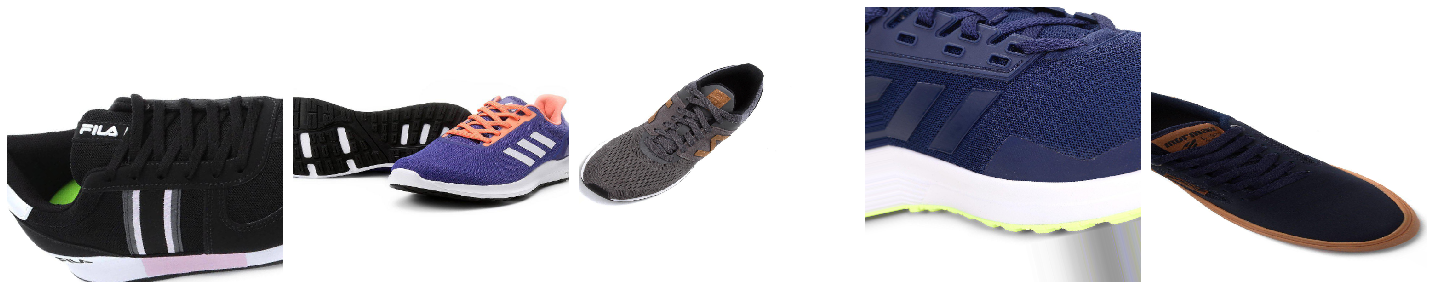

In [15]:
sample_training_images, _ = next(train_data_gen)

plot_images(sample_training_images[:5])

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

In [ ]:
batch_stats_callback = CollectBatchStats()

epochs = 2

history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size
#     callbacks = [batch_stats_callback]
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 64 steps, validate for 11 steps
Epoch 1/2


# Cor